In [1]:
%matplotlib widget

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit
import scipy.interpolate
import scipy.optimize
import os
import lmfit
from tqdm import tqdm
import datetime

import fit_functions
import nekhoroshev_tools

In [3]:
def mm_to_sigma(mm):
    return mm / (0.200 * np.sqrt(4.0 / 3.5))


def scale_factor(vals, sigma_barrier):
    return vals / 1.8e-11


def get_roi(df, from_t, to_t):
    return df[(df["t"] >= from_t) & (df["t"] <= to_t)]

In [4]:
def utc_time_to_seconds(df, baseline):
    df["t"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (
            datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") - datetime.datetime.strptime(baseline["Timestamp (UTC_TIME)"].iloc[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds()
    )
    return df

In [5]:
def get_b_func(barrier_df):
    return scipy.interpolate.interp1d(
        barrier_df["t"], barrier_df["Value"], kind="previous", fill_value="extrapolate"
    )

def get_idx_vals(df, b_func):
    diffs = np.diff(b_func(df["t"]))
    idxs = np.where(diffs > 0.01)[0]
    vals = df["t"].iloc[np.where(diffs > 0.01)]
    return idxs, vals

In [6]:
def get_slices(df, vals, idxs):
    slices = []

    for i in range(len(vals) - 1):
        slices.append((
            df["t"].iloc[idxs[i]: idxs[i+1]].values,
            df["Value"].iloc[idxs[i]: idxs[i+1]].values,
            np.mean(b_func(df["t"].iloc[idxs[i]+1: idxs[i+1]-1].values)),
            (idxs[i], idxs[i+1])
        ))
    return slices

In [7]:
def reset_indexes(df, slices, idxs, b_func, slice_val=5):
    new_slices = []
    for i, s in enumerate(slices[:]):
        if i == 0:
            new_left = np.argmin(s[1][:slice_val]) + s[3][0]
        else:
            data = np.concatenate((
                slices[i-1][1][-slice_val:],
                slices[i][1][:slice_val]
            ))
            rel_index = np.argmin(data)
            if rel_index < slice_val:
                new_left = slices[i-1][3][1] + rel_index
            else:
                new_left = slices[i][3][0] + rel_index - slice_val
        
        if i == len(slices) - 1:
            new_right = np.argmax(s[1][-slice_val:]) + s[3][1] - slice_val
        else:
            data = np.concatenate((
                slices[i][1][-slice_val:],
                slices[i+1][1][:slice_val]
            ))
            rel_index = np.argmax(data)
            if rel_index < slice_val:
                new_right = slices[i][3][1] + rel_index - slice_val
            else:
                new_right = slices[i+1][3][0] + rel_index - slice_val

        new_slices.append((
            df["t"].values[new_left: new_right],
            df["Value"].values[new_left: new_right],
            np.mean(b_func(df["t"].values[idxs[i]+1: idxs[i+1]-1])),
            (new_left, new_right)
        ))
    return new_slices

In [8]:
def get_spline(slices):
    x = []
    y = []
    for s in slices:
        try:
            x.append(s[0][-1])
            y.append(s[1][-1])
        except:
            pass
    spline = scipy.interpolate.UnivariateSpline(
    np.asarray(x), np.log10(y), k=3, s=1) 

    return lambda x: np.power(10, spline(x))

In [9]:
def compose_fit_lists(slices, spline, samples_per_slice=20, spline_multiplier=1.0):
    x_raw = []
    all_raw = []
    x_list = []
    y_list = []

    for i in range(1, len(slices)):
        try:
            from_value = slices[i-1][2]
            to_value = slices[i][2]
            times = slices[i][0] - slices[i][0][0] 
            times[0] += times[1] * 0.2 # so that it's not zero
            the_function = spline(slices[i][0]) * spline_multiplier
            values = slices[i][1] / the_function
            
            # x_raw.append(slices[i][0])
            # y_raw.append(values)

            if len(values) < samples_per_slice + 1:
                idxs = np.arange(1, len(values))
            else:
                idxs = np.linspace(1, len(values), samples_per_slice, dtype=int, endpoint=False)
            all_raw.append((slices[i][0], values-1))
            
            values = values[idxs]
            times = times[idxs]

            x_raw.append(slices[i][0][idxs])

            x_list.append(("forward", from_value, to_value, times))
            y_list.append(values-1)
        except:
            pass    
    return x_raw, all_raw, x_list, y_list

# 6194 -- Beam 1 -- horizontal

In [10]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/6194_b1_horizontal/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/6194_b1_horizontal/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/6194_b1_horizontal/TCP.C6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [11]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

(1.5, 10.5)

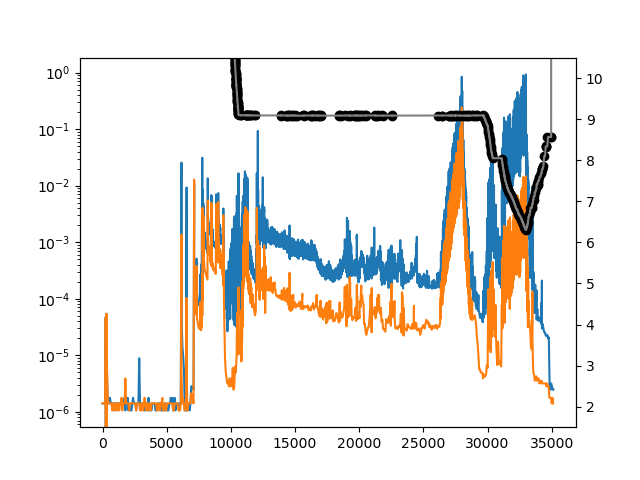

In [12]:
# plt.figure(figsize=(15, 8))
plt.figure()

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

# 6194 -- Beam 1 -- vertical

In [13]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/6194_b1_vertical/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/6194_b1_vertical/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/6194_b1_vertical/TCP.D6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [14]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

(1.5, 10.5)

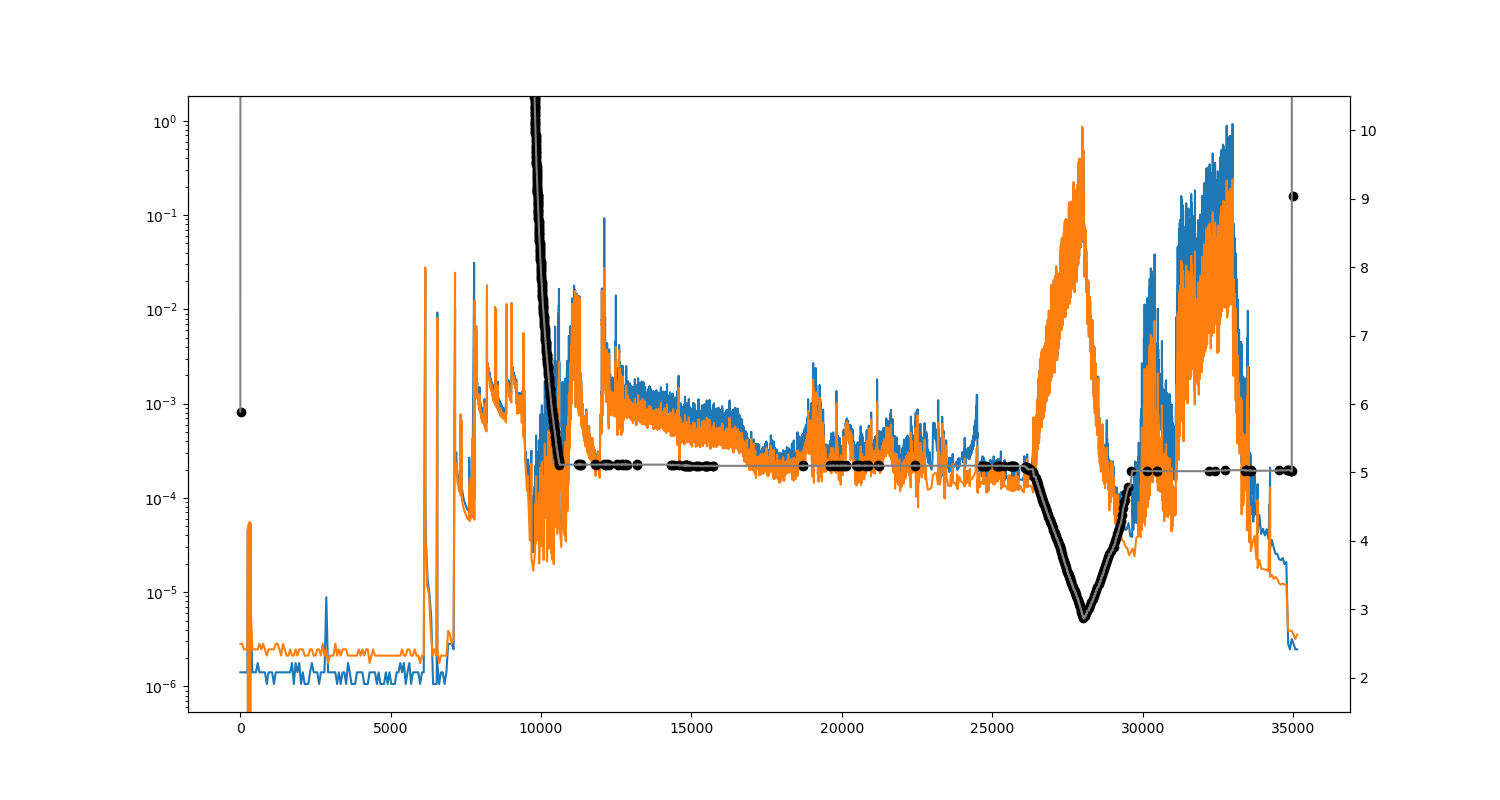

In [15]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

# 6194 -- Beam 2 -- horizontal

In [16]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/6194_b2_horizontal/BLMEI.06R7.B2I10_TCP.A6R7.B2_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/6194_b2_horizontal/BLMEI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/6194_b2_horizontal/TCP.C6R7.B2_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [17]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

(1.5, 10.5)

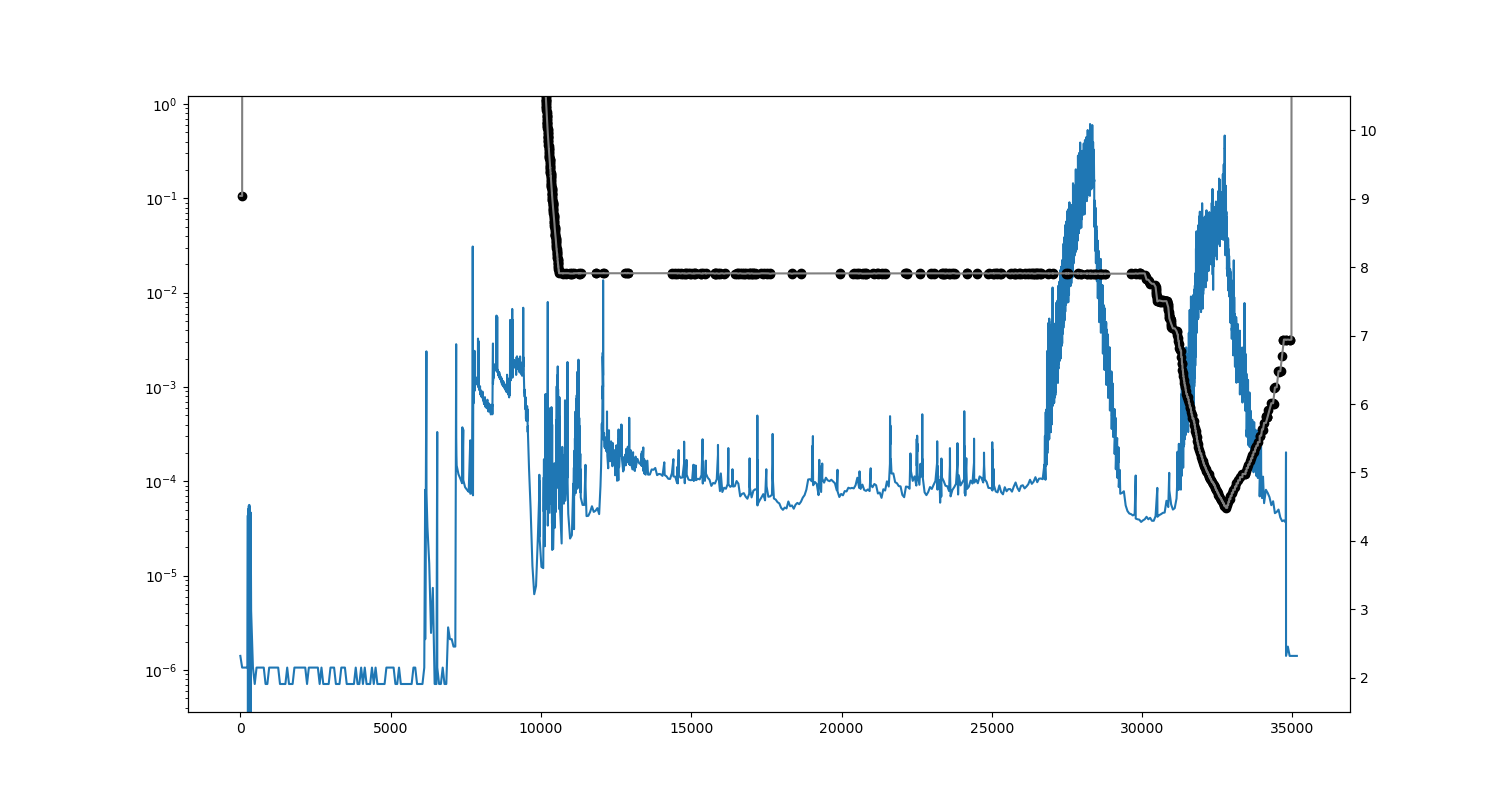

In [18]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

# 6194 -- Beam 2 -- vertical

In [22]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/6194_b2_vertical/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/6194_b2_vertical/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/6194_b2_vertical/TCP.D6R7.B2_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [23]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

(1.5, 10.5)

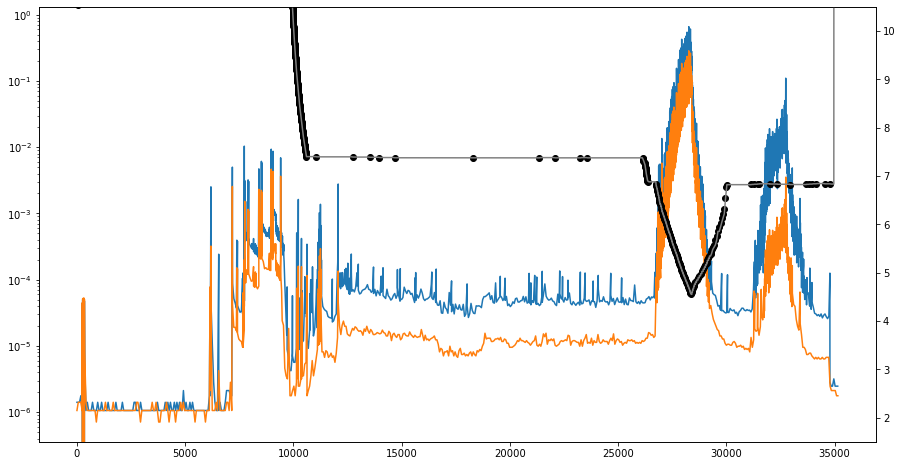

In [24]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

# 7221 -- Beam 1 -- vertical

In [18]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/7221_b1_vertical/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS09.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/7221_b1_vertical/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/7221_b1_vertical/TCP.D6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [19]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

In [20]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1.5, 10.5)

# 7932 -- Beam 1 -- horizontal

In [29]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/7392_b1_horizontal/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/7392_b1_horizontal/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/7392_b1_horizontal/TCP.C6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [30]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

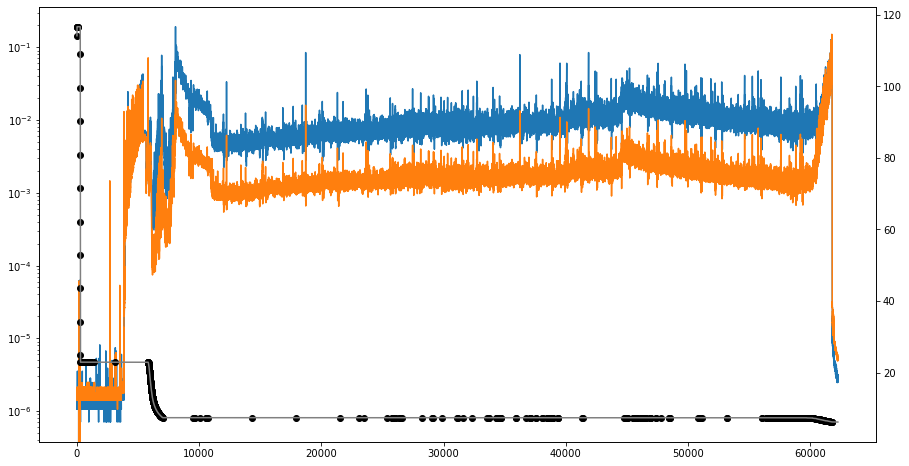

In [43]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

#plt.ylim(1.5, 10.5)

# 7392 -- Beam 1 -- vertical

In [34]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/7392_b1_vertical/BLMEI.06L7.B1E10_TCP.A6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/7392_b1_vertical/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/7392_b1_vertical/TCP.D6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [35]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

(1.5, 10.5)

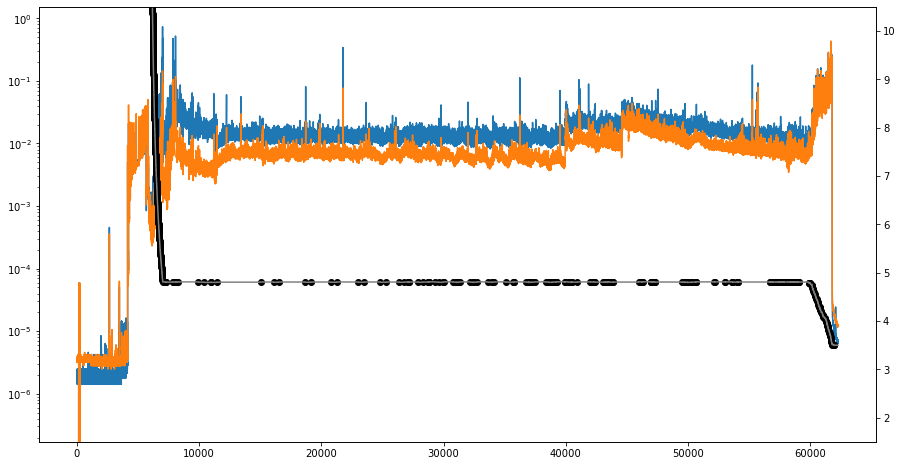

In [36]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

# 7932 -- Beam 2 -- horizontal

In [37]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/7392_b2_horizontal/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/7392_b2_horizontal/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/7392_b2_horizontal/TCP.C6R7.B2_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [38]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

(1.5, 10.5)

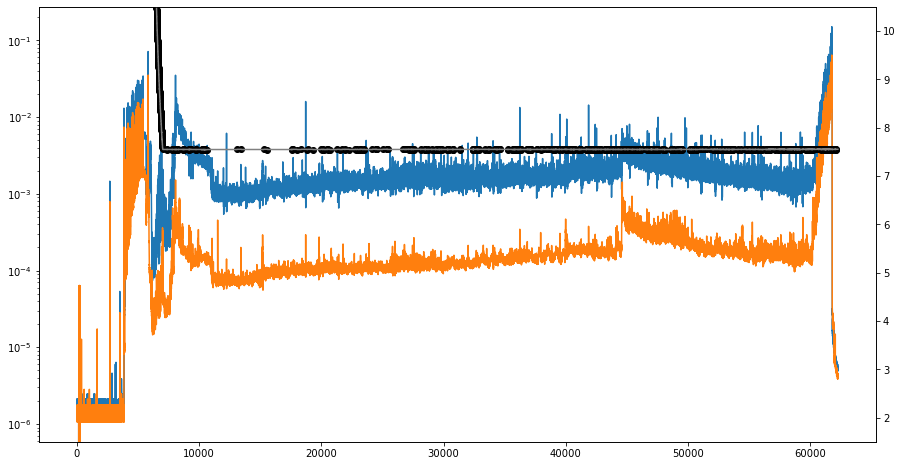

In [39]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

# 7392 -- Beam 2 -- vertical

In [40]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/7392_b2_vertical/BLMEI.06R7.B2I10_TCP.A6R7.B2_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/7392_b2_vertical/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/7392_b2_vertical/TCP.D6R7.B2_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [41]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

(1.5, 10.5)

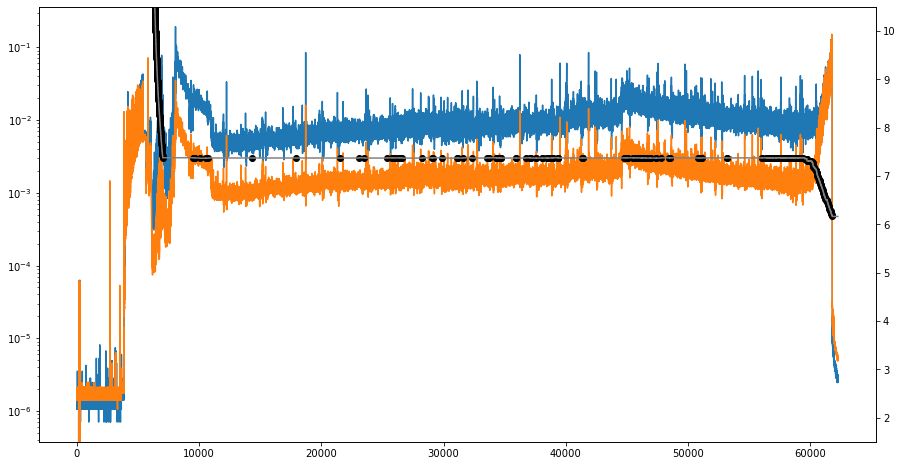

In [42]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

# 7221 -- Beam 2 -- vertical

In [21]:
# read csv file
loss_1_rs6 = pd.read_csv("other_fills/7221_b2_vertical/BLMEI.06R7.B2I10_TCP.A6R7.B2_LOSS_RS06.csv", header=1)
loss_2_rs6 = pd.read_csv("other_fills/7221_b2_vertical/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS06.csv", header=1)

barrier = pd.read_csv("other_fills/7221_b2_vertical/TCP.D6R7.B2_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

In [22]:
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6, loss_1_rs6)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6, loss_1_rs6)

barrier = utc_time_to_seconds(barrier, loss_1_rs6)

In [23]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs6["t"], b_func(loss_1_rs6["t"]), label="Barrier", color="grey")

plt.ylim(1.5, 10.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(1.5, 10.5)